In [1]:
import pandas as pd

In [2]:
patch_responses = pd.read_csv('df_pd_final.csv', usecols= ['upstream', 'responses.message'])
patch_responses.dropna(inplace=True, subset=['upstream'])
# patch_responses.head()

In [3]:
# patch_responses = patch_responses.sample(80000)

In [4]:
from ast import literal_eval

import email

def get_message_date(msg):
    try:
        msg = literal_eval(msg).decode()
        return pd.to_datetime(email.message_from_string(msg)['Date']).date()
    except:
        return None

patch_responses['responses.date'] = patch_responses['responses.message'].map(get_message_date)
patch_responses.drop('responses.message', axis=1, inplace=True)
patch_responses.head()

,upstream,responses.date
245,35714565089e5e8b091c1155517b67e29118f09d,2019-11-01
247,35714565089e5e8b091c1155517b67e29118f09d,2019-11-01
249,35714565089e5e8b091c1155517b67e29118f09d,2019-11-02
251,35714565089e5e8b091c1155517b67e29118f09d,None
252,35714565089e5e8b091c1155517b67e29118f09d,2019-11-01


In [5]:
from pypasta.Repository.Repository import Repository

repo = Repository('./resources/linux/repo')

def get_commit_object(upstream):
    try:
        return repo.get_commit(upstream)
    except:
        return None

def get_author(commit):
    try:
        author = commit.author
        return author.name + ' <' + author.email + '>'
    except:
        return None

def get_changed_lines(commit):
    try:
        return commit.diff.lines
    except:
        return None

def get_patches(commit):
    try:
        return len(commit.diff.patches)
    except:
        return None

def get_date(commit):
    try:
        return commit.committer.date.date()
    except:
        return None

def get_revert(commit):
    try:
        return commit.is_revert
    except:
        return None

In [6]:
upstream = patch_responses[['upstream']].drop_duplicates(keep = False)

In [7]:
upstream['commit'] = upstream['upstream'].apply(get_commit_object)

In [8]:
upstream['author'] = upstream['commit'].apply(get_author)

In [9]:
upstream['date'] = upstream['commit'].apply(get_date)

In [10]:
def get_tags(commit, tag):
    try:
        results = commit.tags[tag]
        if len(results):
            return results
        return None
    except:
        return None

def get_number_of_tags(commit, tag):
    try:
        return len(commit.tags[tag])
    except:
        return 0

In [11]:
upstream['n_reviewers'] = upstream['commit']\
                                .apply(lambda x: get_number_of_tags(x, 'reviewed-by'))

In [12]:
upstream['reported-by'] = upstream['commit']\
                                .apply(lambda x: get_tags(x, 'reported-by'))

In [13]:
upstream['n_reported-by'] = upstream['commit']\
                                .apply(lambda x: get_number_of_tags(x, 'reported-by'))

In [14]:
upstream['fixes'] = upstream['commit']\
                                .apply(lambda x: get_tags(x, 'fixes'))

In [15]:
upstream['n_fixes'] = upstream['commit']\
                                .apply(lambda x: get_number_of_tags(x, 'fixes'))

In [16]:
upstream['lines'] = upstream['commit'].apply(get_changed_lines)

In [17]:
upstream['n_patches'] = upstream['commit'].apply(get_patches)

In [18]:
upstream['is_revert'] = upstream['commit'].apply(get_revert)

### Percentage of revert commits

In [19]:
len(upstream[upstream.is_revert])/len(upstream)*100

1.2090359529112313

## Review coverage percentage
Simply the ratio of the number of reviewers to the number of changed lines for each upstream commit. 1 reviewer for each changed line would mean 100% coverage. Therefore the coverage percentage measure is allowed to exceed 100%.

In [20]:
def coverage(row):
    if row.n_reviewers:
        return (row.n_reviewers/row.lines)*100
    else:
        return 0

In [21]:
upstream['coverage(%)'] =  upstream.apply(coverage, axis=1)

### Average review coverage in the dataset

In [22]:
upstream['coverage(%)'].mean()

3.9785330607414253

## Author Activity Percentage
Measure percentage of the commits in the dataset were made by the author. An author activity of 100% would mean that every commit in the release window we have taken was made by that author.

In [23]:
author_counts = dict(upstream['author'].value_counts())
num_commits = len(upstream)

def author_activity(author):
    return (author_counts[author]/num_commits)*100

upstream['author_activity(%)'] = upstream['author'].apply(author_activity)

In [24]:
upstream.head()

,upstream,commit,author,date,n_reviewers,reported-by,n_reported-by,fixes,n_fixes,lines,n_patches,is_revert,coverage(%),author_activity(%)
877,74cfa956cbead238cf6c5307be461a087c569c97,<pypasta.Repository.Repository.Commit object a...,Baolin Wang <baolin.wang@linaro.org>,2019-10-04,0,None,0,None,0,4,1,False,0.0,0.190900
1034,6206f0e180d4eddc0a178f57120ab1b913701f6e,<pypasta.Repository.Repository.Commit object a...,Jens Axboe <axboe@kernel.dk>,2019-11-26,0,None,0,None,0,82,2,False,0.0,2.131721
3647,180245d2d01686f61b3d1909bdf349a6d153008b,<pypasta.Repository.Repository.Commit object a...,Wambui Karuga <wambui.karugax@gmail.com>,2019-10-14,0,None,0,None,0,4,1,False,0.0,0.286351
3800,d7f9e85082f6ed47731fc5fb591eb65fed9547c6,<pypasta.Repository.Repository.Commit object a...,Mauro Carvalho Chehab <mchehab+samsung@kernel....,2019-10-10,0,None,0,None,0,17,1,False,0.0,0.381801
3982,33a107f0a1b8df0ad925e39d8afc97bb78e0cec1,<pypasta.Repository.Repository.Commit object a...,Jens Axboe <axboe@kernel.dk>,2019-10-29,0,None,0,None,0,21,2,False,0.0,2.131721


## Grouped by dates

### How does the number of patches in each commit change by time?

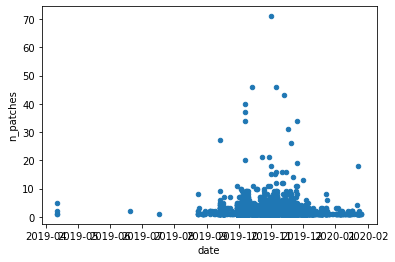

In [25]:
upstream.plot.scatter(x = 'date', y = 'n_patches')

### How does the number of changed lines in each commit change by time?

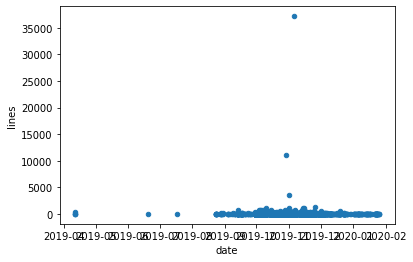

In [26]:
upstream.plot.scatter(x = 'date', y = 'lines')

In [27]:
counts_by_date = upstream.groupby('date').count()\
    [['upstream', 'reported-by', 'fixes']]\
    .reset_index()
counts_by_date.head()

,date,upstream,reported-by,fixes
0,2019-04-11,4,0,3
1,2019-06-20,1,0,0
2,2019-07-17,1,0,0
3,2019-08-23,7,0,1
4,2019-08-24,1,0,0


### Number of new commits each day

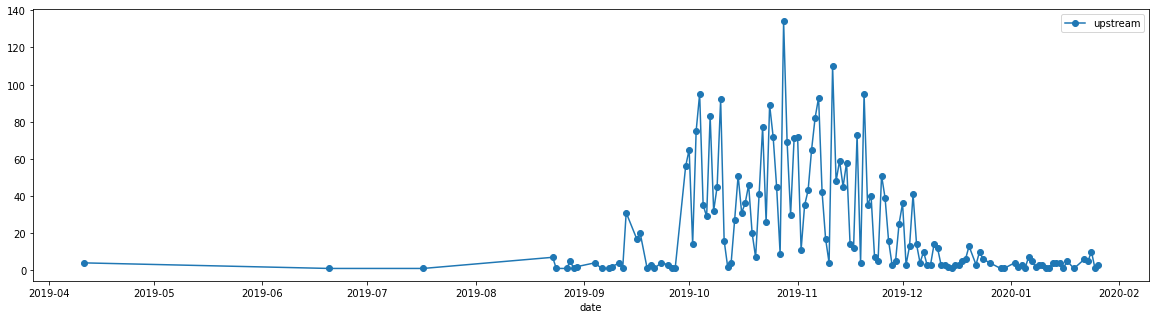

In [28]:
counts_by_date.plot.line(x = 'date', y = 'upstream',  marker='o', figsize=(20, 5))

### Number of commits with a reported-by tag each day

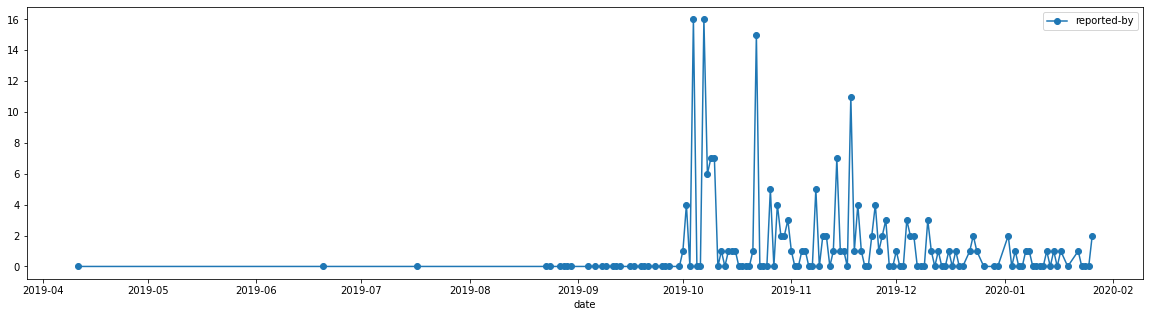

In [29]:
counts_by_date.plot.line(x = 'date', y = 'reported-by', figsize=(20, 5), marker='o')

### Number of commits with fixes each day
Each dot represents a commit

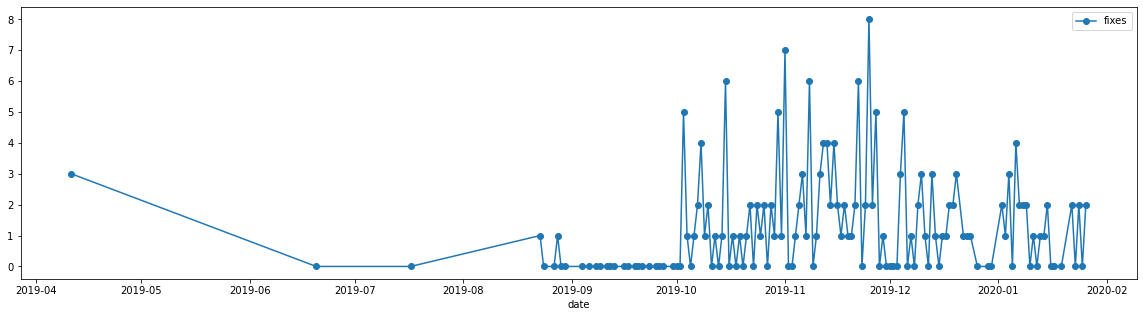

In [30]:
counts_by_date.plot.line(x = 'date', y = 'fixes', figsize=(20, 5), marker='o')

### Number of revert commits each day

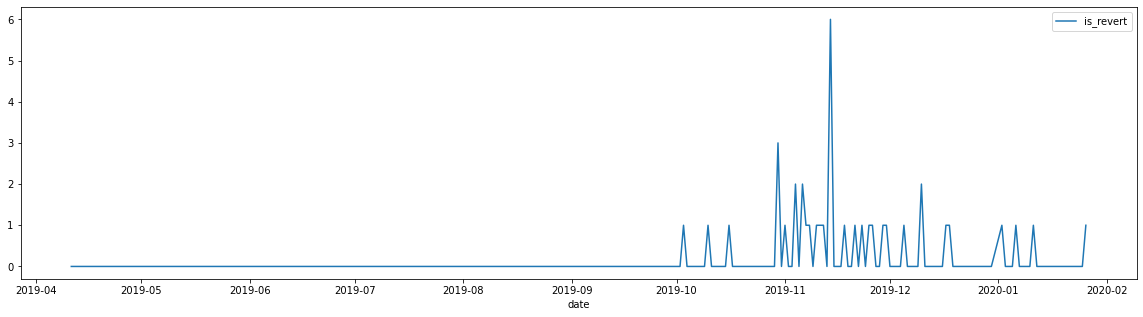

In [31]:
 upstream.groupby('date').sum().reset_index().plot.line(x = 'date', y = 'is_revert', figsize=(20, 5))

### Discussion Period
Days difference between the commit date and the first email response referencing the commit. Negative value would mean that the first response was after the commit date.

In [32]:
def get_discussion_period(row):
    try:
        return (row.date - min(patch_responses[patch_responses.upstream == row.upstream]['responses.date'])).days
    except:
        return None

In [33]:
upstream['discussion_period'] = upstream.apply(get_discussion_period, axis = 1) 

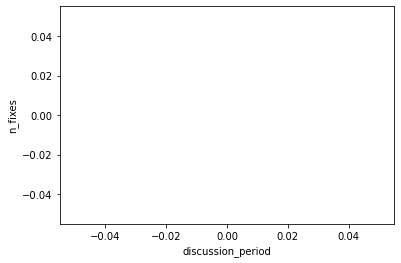

In [34]:
upstream.plot.scatter(x = 'discussion_period', y = 'n_fixes')#, logx=True, logy=True)

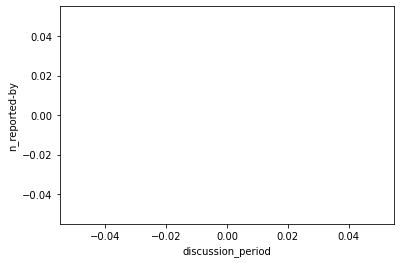

In [35]:
upstream.plot.scatter(x = 'discussion_period', y = 'n_reported-by')#,commit.date logx=True, logy=True)